# 5. Investigating Survival/Recurrace
This notebook is for exploring the connection between survival rate in TNBC and spacial distribution of TILs.

In [25]:
import pandas as pd
from itertools import combinations
import regex as re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from dataset import TNBC2
import os
import numpy as np
from numba import jit
from tqdm import tqdm
import matplotlib

sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})
matplotlib.rcParams['font.family'] = "serif"


In [26]:
df_pat = pd.read_excel('../data/tnbc2/256_TNBC__F_LEION_till_arvid.xlsx')
df_pat = df_pat.replace(-0.99, np.NaN)
df_pat = df_pat.replace("N/D", np.NaN)

df_pat["nodes"] = df_pat["Positive nodes"]
df_pat["age"] = df_pat["Age at diagnosis"]

df_pat["treated"] = df_pat["Chemo (schema)"].apply(lambda x: x != "None")
df_pat["relapse"] = df_pat["Relapse yes 1 no 0"].astype(np.bool)
df_pat["dead"] = df_pat["Dead yes 1 no 0"].astype(np.bool)
df_pat["OS"] = df_pat["OS yes 1 no 0"]
df_pat["IDFS"] = df_pat["IDFS yes 1 no 0"].astype(np.bool)
df_pat["DRFI"] = df_pat["DRFI Breast cancer spec"].astype(np.bool)

df_pat["distant_relapse"] = (df_pat["Months_surgery_distant_relapse"] > 0)
df_pat["local_relapse"] = (df_pat["relapse"].apply(int) - df_pat["distant_relapse"].apply(int)) > 0

df_pat["nodes"] = df_pat["nodes"].astype(float)

In [27]:
(df_pat["OS"] | df_pat["dead"]).value_counts()
df_pat["dead"].value_counts()

False    171
True      50
Name: dead, dtype: int64

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.spatial import distance

def _image_path(patient_id):
    block, letters, numbers = _tma_id(patient_id)
    paths = []
    dataset = TNBC2()
    for let, num in zip(letters, numbers):
        for file in os.listdir(dataset.image_dir):
            b, n, l = re.findall(r"Block_(\d).*_(.*)_([A-Z])_", file)[0]
            if int(b) == block and int(n) == num and l == let:
                paths.append(dataset.image_dir / file)
    return paths

def display(tma_id):
    plt.figure(figsize=(20,10))
    for n, path in enumerate(_image_path(tma_id), 1):
        plt.subplot(1,2,n)
        plt.imshow(imread(path))
        
def correlation(df, features):
    corrmat = df[features].corr(method='spearman')
    plt.figure(figsize=(8,8))
    sns.clustermap(corrmat, vmin=-1, cmap="YlGnBu", linewidth=0.1, annot=True)
    
def corrfunc(df, **kws):
    x, y = zip(*df.dropna().values)
    (r, p) = pearsonr(x, y)
    ax = plt.gca()
    ax.set_title(f"r = {r:.2f}, p = {p:.2E}")
    

## Split TILs into stromal and intratumoral

<img src="../docs/stromal_intratumoral_tils.png" width="500" align="left"/>


In [29]:

def tumor_stroma_tils(immune_loc, tumor_loc, radius=[60], factor=2.0):
    """ Estimates which immune cells are Stromal TILs and which
        are Intratumoral."""
    n_tils= {}
    
    tumor_loc = np.array([list(coord) for coord in tumor_loc], np.float32)
    immune_loc = np.array([list(coord) for coord in immune_loc], np.float32)
    
    if len(immune_loc) == 0 or len(tumor_loc) == 0:
        return {}
    
    tumor_dist = distance.cdist(tumor_loc,immune_loc)
    immune_dist = distance.cdist(immune_loc,immune_loc)
    
    for r in radius:
        tumor_within_r = tumor_dist < r
        immune_within_r = immune_dist < r
    
        n_tumor_within = tumor_within_r.sum(axis=0)
        n_immune_within = immune_within_r.sum(axis=0)
    
        n_tils[f"t_tils_{r}"] = (n_tumor_within > n_immune_within*factor).astype(np.uint8).sum()
        n_tils[f"s_tils_{r}"] = (n_tumor_within*factor < n_immune_within).astype(np.uint8).sum()
        
    return n_tils

def ripleys_k(locations, radius=[200, 250, 300]):
    """en.wikipedia.org/wiki/Spatial_descriptive_statistics#Ripley.27s_K_and_L_functions"""
    if len(locations) == 0:
        return dict([
            (f"k_{r}" , np.NaN) for r in radius
        ])
    locations = np.array([list(coord) for coord in locations], np.float32)
    n = locations.shape[0]
    distances = distance.cdist(locations, locations)
    return dict([
        (f"k_{r}" , 1024**2*np.sum(distances[0,1:] < r) / n**2) for r in radius
    ])


size = 8
def display_cells(df):
    tnbc = TNBC2()
    for n, row in df.iterrows():
        immune_loc = row["immune_loc"]
        tumor_loc = row["tumor_loc"]
        imid = row["image_id"]
        img = tnbc.load_image(imid)

        tumor_tils, stroma_tils = tumor_stroma_tils(immune_loc, tumor_loc)

        plt.figure(figsize=(20,10))
        plt.subplot(121)
        plt.imshow(img)
        plt.subplot(122)
        ax = plt.gca()
        ax.invert_yaxis()
        args = lambda locs: list(zip(*locs))[::-1]
        plt.title(f"Tumor cells: {len(tumor_loc)}\n TILs: {len(immune_loc)}")
        plt.scatter(*args(tumor_loc), label="Tumor cells", s=size)
        #plt.scatter(*args(immune_loc), label="TILs", s=size)
        plt.scatter(*args(tumor_tils), label="Intratumoral TILs", s=size)
        plt.scatter(*args(stroma_tils), label="Stromal TILs", s=size)
        plt.legend()
    
def pat_id_wsi(image_id):
    try:
        return int(re.findall(r"\d+", image_id)[0])
    except:
        return np.NaN

def pat_id_tma(image_name):
    block,  nr, letter = re.findall(r"Block_(\d).*_(.*)_([A-Z])_", image_name)[0]
    block_start = [1, 59, 113, 172, 210]
    start = block_start[int(block)-1]
    
    letter = letter.lower()
    key = np.array([i for i in range(start, start + int(10*12/2)) for n in range(2)]).reshape((10,12))
    pat_id = key[int(nr)-1][11 - (ord(letter) - 97)]
    return pat_id
    
def _tma_id(patient_id):
    block_start = [1, 59, 113, 172, 210]
    start = [s for s in block_start if patient_id >= s][-1]
    block = block_start.index(start) + 1
            
    key = np.array([i for i in range(start, start + int(10*12/2)) for n in range(2)]).reshape((10,12))
    Y, X = np.where(key == patient_id) 
    letters = [chr(11 - (x - 97)).upper() for x in X]
    numbers = list(Y + 1)
    return block, letters, numbers
    

In [6]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    pass
    #print(df_wsi.sort_values("TMAid"))
    #print(df_wsi["TMAid"].value_counts())

In [33]:
from joblib import Memory

memory = Memory('./cache/')

def extract_features(path):
    df = pd.read_feather(path)
    
    n_tils = ([
        tumor_stroma_tils(imloc, tumloc, [10, 50, 100])
        for imloc, tumloc in tqdm(zip(df["immune_loc"], df["tumor_loc"]), total=len(df))
    ])
    df = pd.concat([df, pd.DataFrame(n_tils)], axis=1)
    
    r = [10, 100, 300]
    df_immune_k = pd.DataFrame([ripleys_k(imloc, r) for imloc in tqdm(df["immune_loc"])])
    df = pd.concat([df, df_immune_k.add_prefix("immune_")], axis=1)
                                     
    df_tumor_k = pd.DataFrame([ripleys_k(tumloc, r) for tumloc in tqdm(df["tumor_loc"])])
    df = pd.concat([df, df_tumor_k.add_prefix("tumor_")], axis=1)
    return df


def merge_patient_data_wsi(df_wsi, df_pat):
    df_pat["STR"] = df_pat["TILs helsnitt"]
    df_mean = df_wsi.groupby("image_id").mean().reset_index()
    df_mean["TMAid"] = df_mean["image_id"].apply(pat_id_wsi)
    df_all = pd.merge(df_pat, df_mean, how='inner', on=["TMAid"])
    return df_all

def merge_patient_data_tma(df_tma, df_pat):
    df_pat["STR"] = df_pat["TILs TMA"]
    df_tma["TMA_id"] = df_tma["image_id"].apply(pat_id_tma)
    df_mean = df_tma.groupby("TMA_id").mean().reset_index()
    df_all = pd.merge(df_pat, df_mean, how='inner', on=["TMAid"])

    return df_all


In [34]:
df_tma = extract_features('./tma_quip2_0.2_5_1.0.feather')
df_all = merge_patient_data_tma(df_tma, df_pat)
IMAGE_TYPE = "TMA"

In [60]:
df_wsi = extract_features('./wsi_quip2_0.2_5_1.0_800.feather')
df_all = merge_patient_data_wsi(df_wsi, df_pat)
IMAGE_TYPE = "WSI"

100%|██████████| 210537/210537 [01:36<00:00, 2182.45it/s]


In [61]:
df_treated = df_all[df_all["treated"]]
df_treated.to_pickle(f"./df_treated_{IMAGE_TYPE}.pickle")

In [35]:
def plot_compare(ylabels, xlabels, df, **kwargs):
    plt.figure(figsize=(5*len(ylabels),4))
    features = [[x, y] for x in xlabels for y in ylabels]
    for n, feat in enumerate(features, 1):
        plt.subplot(1,len(ylabels),n)
        sns.scatterplot(data=df, x=feat[0], y=feat[1], **kwargs)
        corrfunc(df[feat])

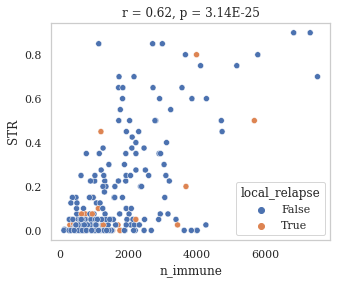

In [36]:
plot_compare(["STR"], ["n_immune"], df_all, hue="local_relapse")

In [58]:
import statsmodels.api as sm
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import seaborn as sn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC as SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from numpy.linalg import LinAlgError
from statsmodels.tools.sm_exceptions import PerfectSeparationError
from sklearn.neural_network import MLPClassifier


def _results_to_pandas(summary):
    return pd.read_html(summary.tables[1].as_html(), header=0, index_col=0)[0]

def logit(x_train, y_train, x_val, y_val):
    try:
        model = sm.Logit(y_train, x_train).fit(disp=False)
        return model.predict(x_val), model
    except (LinAlgError, PerfectSeparationError):
        return np.random.rand(*y_val.shape), None
        
def logit_sklearn(x_train, y_train, x_val, y_val):
    model = LogisticRegression()
    model.fit(x_train, y_train.ravel())
    return model.predict(x_val)

def scv(x_train, y_train, x_val, y_val):
    model = SVC(max_iter=80000)
    model.fit(x_train, y_train.ravel())
    return model.predict(x_val), None

def mlp(x_train, y_train, x_val, y_val):
    model = MLPClassifier((5,2), max_iter=9000)
    model.fit(x_train, y_train.ravel())
    return model.predict(x_val), None

def random_forest(x_train, y_train, x_val, y_val):
    model = RandomForestClassifier()
    model.fit(x_train, y_train.ravel())
    return model.predict(x_val), None

def cross_validation(y, X, model = logit):
    if len(y.shape) > 1:
        y = y.iloc[:,0]

    X = (X-X.mean())/X.std()
    X["Intercept"] = 1.0
    
    true, pred, = ([], [])
    summaries = []
    
    cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    for train_val_idx, test_idx in cv_outer.split(X, y):
        X_train_val, X_test = X.iloc[train_val_idx], X.iloc[test_idx]
        y_train_val, y_test = y.iloc[train_val_idx], y.iloc[test_idx]

        cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
        for train_idx, val_idx in cv_inner.split(X_train_val, y_train_val):
            x_train, x_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
            y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]

            #x_train, y_train = pipeline.fit_resample(x_train, y_train)
            
            y_pred, m = model(x_train, y_train, x_val, y_val)
            true.extend(list(y_val))
            pred.extend(list(y_pred))
            if m:
                summaries.append(_results_to_pandas(m.summary()))
                
    if summaries:
        result = sum(summaries) / len(summaries)
    else:
        result = None
        
    return true, pred, result

def cross_validation_test(y, X, model = logit):
    if len(y.shape) > 1:
        y = y.iloc[:,0]

    X = (X-X.mean())/X.std()
    X["Intercept"] = 1.0
    
    true, pred, = ([], [])
    summaries = []
    
    cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    for train_val_idx, test_idx in cv_outer.split(X, y):
        X_train_val, X_test = X.iloc[train_val_idx], X.iloc[test_idx]
        y_train_val, y_test = y.iloc[train_val_idx], y.iloc[test_idx]

        print(len(X_test))
        y_pred, m = model(X_train_val, y_train_val, X_test, y_test)
        true.extend(list(y_test))
        pred.extend(list(y_pred))
        if m:
            summaries.append(_results_to_pandas(m.summary()))
                
    if summaries:
        result = sum(summaries) / len(summaries)
    else:
        result = None
        
    return true, pred, result

In [38]:
from itertools import combinations, chain, product, permutations
from tqdm import tqdm
from patsy import dmatrices, dmatrix
from scipy.stats import pearsonr
group = ["distant_relapse"]

image_features = set([
    "STR",
    "n_immune",
    "n_tumor",
    "tumor_area",
    "immune_area",
    'tumor_k_100',
    'immune_k_100',
    "t_tils_100",
    "s_tils_100",
])

pat_features = set(['age', 'nodes'])
all_features = image_features.union(pat_features)

def label(feature):
    r = re.findall("\d{1,3}", feature)
    if feature == "n_immune":
        return "$N_i$"
    elif feature == "n_tumor":
        return "$N_t$"
    elif feature == "immune_area":
        return "$A_i$"
    elif feature == "tumor_area":
        return "$A_t$"
    elif feature.startswith("s_tils"):
        return "$N_{is}(" + r[0] + ")$"
    elif feature.startswith("t_tils"):
        return "$N_{it}(" + r[0] + ")$"
    elif feature.startswith("immune_k"):
        return "$K_{i}(" + r[0] + ")$"
    elif feature.startswith("tumor_k"):
        return "$K_{t}(" + r[0] + ")$"
    elif feature == "nodes":
        return "$N_n$"
    elif feature == "STR":
        return feature
    else:
        return feature.title()

pd.options.mode.chained_assignment = None

def try_interactions(data, features, target, n_features = [1], test=False):
    d = []
    for f in tqdm(list(chain(*[combinations(features, i) for i in n_features]))):
        f = list(f)
        nona = data[f + [target]].dropna()
        y = nona[target]
        X = nona[f]
        if test:
            true, pred, results = cross_validation_test(y, X, logit)
        else:
            true, pred, results = cross_validation(y, X, logit)
            
        auc = roc_auc_score(true, pred)
        fpr, tpr, thresholds = roc_curve(true, pred)
        d.append({
            "formula" : f,
            "AUC" : auc,
            "tpr" : tpr,
            "fpr" : fpr,
            "thresh" : thresholds,
            "model" : results,
            "target" : target
        })
            
    return pd.DataFrame(d).sort_values("AUC", ascending=False).reset_index()

def best_features(df,features, target, n=10):
    result = []
    for f in features:
        y, X = dmatrices(f"{target} ~ {f}", df, NA_action='drop', return_type='dataframe')
        true, pred, _ = cross_validation(y, X, logit)
        auc = roc_auc_score(true, pred)
        result.append((f, auc))
        
    return [f[0] for f in sorted(result, key = lambda x: x[1], reverse=True)[:n]]

def filter_correlated(df, corr_limit = 0.9):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > corr_limit)]
    return df.drop(to_drop, axis=1)

def high_correlation(df, corr_limit):
    return [(a,b) for a, b in combinations(df.columns, 2)
            if df[[a,b]].corr().iloc[0,1] > corr_limit]

def worse_predictor(df, feature_pairs, target):
    f = []
    for a, b in feature_pairs:
        f.append(min(a,b, key = lambda x: auc_formula(df, f"{target} ~ {x}")))
    return set(f)

def auc_formula(data, formula, test=False):
    y, X = dmatrices(formula, data, NA_action='drop', return_type='dataframe')
    if test:
        true, pred, m = cross_validation_test(y, X, logit)
    else:
        true, pred, m = cross_validation(y, X, logit)
    auc = roc_auc_score(true, pred)
    fpr, tpr, _ = roc_curve(true, pred)
    return fpr, tpr, auc, m


In [59]:
# All single image features
test = True
n_features = [1]
feat = image_features
df_treated = df_all[df_all["treated"]]
distant_img = try_interactions(df_treated,  feat, "distant_relapse", n_features, test=test)
local_img = try_interactions(df_treated, feat, "local_relapse", n_features, test=test)
dead_img = try_interactions(df_treated, feat, "dead", n_features, test=test)

def format_df(df):
    df["label"] = df["formula"].apply(lambda x: label(x[0]))
    df["coef"] = df["model"].apply(lambda x: x.iloc[0]["coef"])
    df = df.round(2)
    return df[["label", "AUC", "coef"]].add_prefix(df["target"].iloc[0]+"_")

latex = pd.concat([format_df(distant_img),
           format_df(local_img),
           format_df(dead_img)], axis=1).to_latex(index=False, escape=False)
print(latex)

 11%|█         | 1/9 [00:00<00:00,  9.38it/s]

31
31
31
31
30
31
31
31
31
30
31
31
31


 56%|█████▌    | 5/9 [00:00<00:00, 11.71it/s]

31
30
31
31
31
31
30
31
31
31
31
30
31
31
31
31


 78%|███████▊  | 7/9 [00:00<00:00, 12.64it/s]

30
31
31
31
31
30
31
31
31
31
30
31
31
31
31
30


 22%|██▏       | 2/9 [00:00<00:00, 14.58it/s]

31
31
31
31
30
31
31
31
31
30
31
31
31
31
30


 67%|██████▋   | 6/9 [00:00<00:00, 14.83it/s]

31
31
31
31
30
31
31
31
31
30
31
31
31
31
30
31


  0%|          | 0/9 [00:00<?, ?it/s]

31
31
31
30
31
31
31
31
30
31
31
31
31
30
31
31


 22%|██▏       | 2/9 [00:00<00:00, 14.87it/s]

31
31
30
31
31
31
31
30
31
31
31
31
30
31
31
31


 67%|██████▋   | 6/9 [00:00<00:00, 15.03it/s]

31
30
31
31
31
31
30
31
31
31
31
30
31
31
31


100%|██████████| 9/9 [00:00<00:00, 15.07it/s]


31
30
31
31
31
31
30
31
31
31
31
30
\begin{tabular}{lrrlrrlrr}
\toprule
distant_relapse_label &  distant_relapse_AUC &  distant_relapse_coef & local_relapse_label &  local_relapse_AUC &  local_relapse_coef &     dead_label &  dead_AUC &  dead_coef \\
\midrule
                $N_i$ &                 0.64 &                 -0.99 &                 STR &               0.57 &               -0.49 &          $N_i$ &      0.60 &      -0.49 \\
                $A_i$ &                 0.62 &                 -0.71 &       $N_{is}(100)$ &               0.55 &               -0.56 &  $N_{is}(100)$ &      0.60 &      -0.62 \\
        $N_{is}(100)$ &                 0.57 &                 -1.45 &        $K_{t}(100)$ &               0.41 &               -0.21 &          $A_i$ &      0.58 &      -0.36 \\
                $N_t$ &                 0.54 &                 -0.24 &        $K_{i}(100)$ &               0.41 &                0.14 &            STR &      0.53 &      -0.11 \\
                  STR & 

In [57]:
# Best features according to validation score
test = False
features = all_features
n_features = range(1,12)
df_treated = df_all[df_all["treated"]]
distant_treated = try_interactions(df_treated,  features, "distant_relapse", n_features, test=test)
local_treated = try_interactions(df_treated,features, "local_relapse", n_features, test=test)
dead_treated = try_interactions(df_treated, features, "dead", n_features, test=test)

  2%|▏         | 40/2047 [00:12<10:34,  3.16it/s]


KeyboardInterrupt: 

In [43]:
pd.concat([distant_treated,
          local_treated,
          dead_treated]).to_pickle(f"combinations_{IMAGE_TYPE}.pickle")

In [ ]:
# All single patient data predictors
test = True
n_features = [1]
df_treated_pat = df_pat[df_pat["treated"]]
distant_pat = try_interactions(df_treated_pat,  pat_features, "distant_relapse", n_features, test=test)
local_pat = try_interactions(df_treated_pat, pat_features, "local_relapse", n_features, test=test)
dead_pat = try_interactions(df_treated_pat, pat_features, "dead", n_features, test=test)

latex = pd.concat([format_df(distant_pat),
           format_df(local_pat),
           format_df(dead_pat)], axis=1).to_latex(index=False, escape=False)
print(latex)

all ['$N_i$'] 0.71
model ['$N_i$'] 0.71
pat ['Age'] 0.5
str ['STR'] distant_relapse ~ -1 + STR 0.62
155
155
155
155
all ['$N_i$', '$N_{is}(100)$', '$N_{it}(100)$'] 0.76
model ['$N_i$', '$N_{is}(100)$', '$N_{it}(100)$'] 0.76
pat ['Age'] 0.42
str ['STR'] local_relapse ~ -1 + STR 0.69
155
155
155
155
all ['$N_{is}(100)$', '$N_{it}(100)$', 'Age', '$N_t$'] 0.74
model ['$N_i$', '$N_{it}(100)$', '$N_t$'] 0.71
pat ['Age'] 0.66
str ['STR'] dead ~ -1 + STR 0.62
155
155
155
155
all ['STR', '$A_i$', '$K_{i}(100)$', '$N_n$', '$N_i$'] 0.69
model ['$A_i$', '$K_{i}(100)$', '$N_t$', '$N_i$'] 0.68
pat ['$N_n$'] 0.58
str ['STR'] distant_relapse ~ -1 + STR 0.53
154
154
154
154
all ['$N_t$', '$N_{it}(100)$', '$A_t$'] 0.52
model ['$N_t$', '$N_{it}(100)$', '$A_t$'] 0.52
pat ['Age'] 0.41
str ['STR'] local_relapse ~ -1 + STR 0.5
154
154
154
154
all ['STR', '$A_i$', 'Age', '$N_t$', '$N_i$'] 0.66
model ['$N_t$', '$N_{is}(100)$', '$N_{it}(100)$'] 0.61
pat ['Age', '$N_n$'] 0.65
str ['STR'] dead ~ -1 + STR 0.45
154

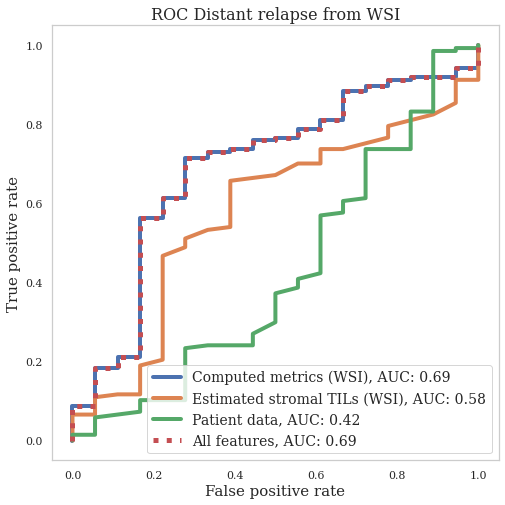

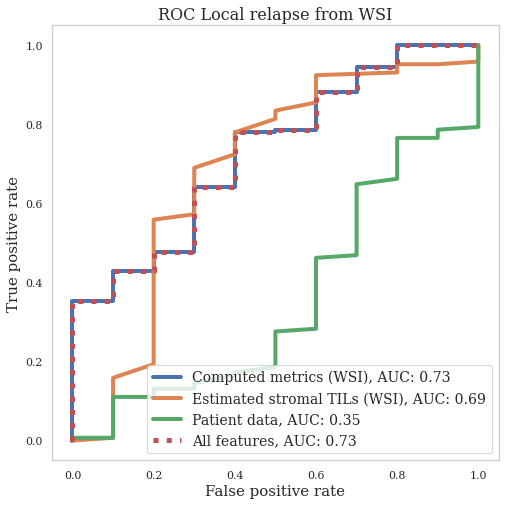

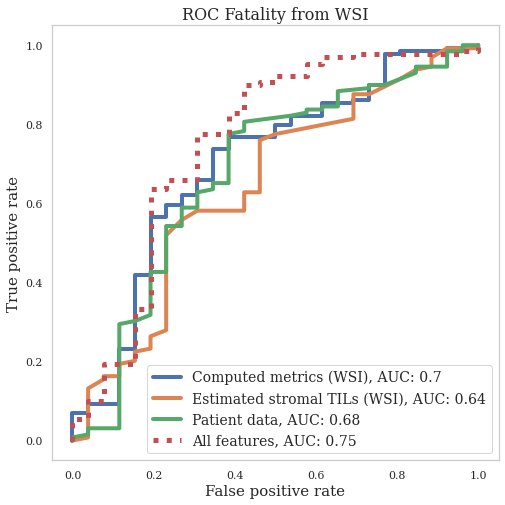

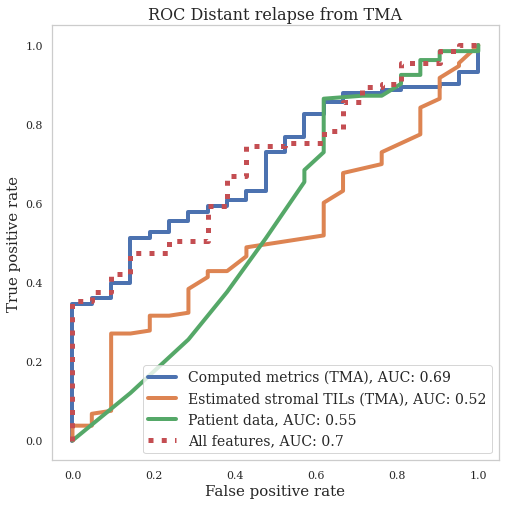

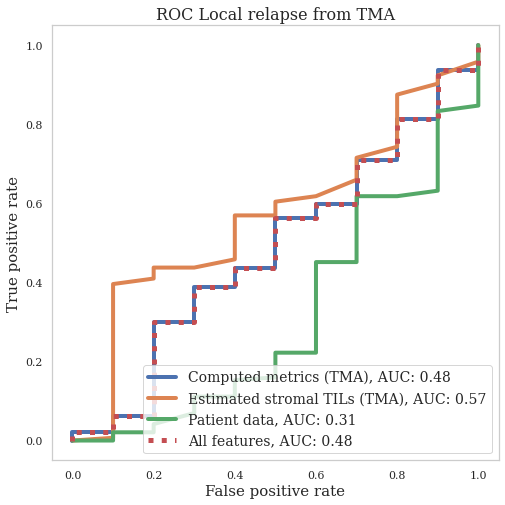

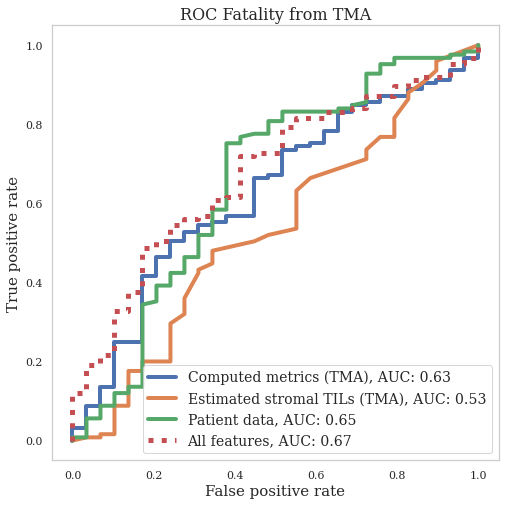

In [55]:
def plot_roc(df, df_treated, img_type):
    r = lambda x: round(x, 2)
    selected_all = df["formula"].iloc[0]
    selected_model = df[df["formula"].apply(lambda x: "STR" not in x and not set(x).intersection(pat_features))]["formula"].iloc[0]
    selected_pat = df[df["formula"].apply(lambda x: not set(x).intersection(image_features))]["formula"].iloc[0]

    formula_all = f"{df['target'].iloc[0]} ~ -1 + {'+'.join(selected_all)}"
    formula_model = f"{df['target'].iloc[0]} ~ -1 + {'+'.join(selected_model)}"
    formula_pat = f"{df['target'].iloc[0]} ~ -1 + {'+'.join(selected_pat)}"
    formula_str = f"{df['target'].iloc[0]} ~ -1 + STR"

    _, _, auc_val_all, _ = auc_formula(df_treated, formula_all, test=False)
    _, _, auc_val_model, _ = auc_formula(df_treated, formula_model, test=False)
    _, _, auc_val_pat, _ = auc_formula(df_treated, formula_pat, test=False)
    _, _, auc_val_str, _ = auc_formula(df_treated, formula_str, test=False)

    print("all", [label(f) for f in selected_all], round(auc_val_all, 2))
    print("model",  [label(f) for f in selected_model], round(auc_val_model,2 ))
    print("pat",  [label(f) for f in selected_pat], round(auc_val_pat, 2))
    print("str",  ["STR"], formula_str, round(auc_val_str, 2))

    fpr_all, tpr_all, auc_all, res = auc_formula(df_treated, formula_all, test=True)
    fpr_model, tpr_model, auc_model, res = auc_formula(df_treated, formula_model, test=True)
    fpr_pat, tpr_pat, auc_pat, res = auc_formula(df_treated, formula_pat, test=True)
    fpr_str, tpr_str, auc_str, res = auc_formula(df_treated, formula_str, test=True)

    plt.plot(fpr_model, tpr_model, label=f"Computed metrics ({img_type}), AUC: {r(auc_model)}", linewidth=4)
    plt.plot(fpr_str, tpr_str, label=f"Estimated stromal TILs ({img_type}), AUC: {r(auc_str)}", linewidth=4)
    plt.plot(fpr_pat, tpr_pat, label=f"Patient data, AUC: {r(auc_pat)}", linewidth=4)
    
    plt.plot(fpr_all, tpr_all, label=f"All features, AUC: {r(auc_all)}", linewidth=5, linestyle=':')
    plt.ylabel("True positive rate", fontsize=15)
    plt.xlabel("False positive rate", fontsize=15)
    plt.legend(fontsize=14, loc = "lower right")
    
fig_options = {
   'bbox_inches' : 'tight' 
}
IMAGE_TYPE = "WSI"
font_size_title = 16
df = pd.read_pickle(f"./combinations_{IMAGE_TYPE}.pickle")
df_treated = pd.read_pickle(f"./df_treated_{IMAGE_TYPE}.pickle")

plt.figure(figsize=(8,8))
plt.title(f"ROC Distant relapse from {IMAGE_TYPE}", fontsize=font_size_title)
target = "distant_relapse"
plot_roc(df[df["target"] == target], df_treated, IMAGE_TYPE)
plt.savefig(f"../docs/roc_{IMAGE_TYPE}_{target}.svg", **fig_options)

plt.figure(figsize=(8,8))
plt.title(f"ROC Local relapse from {IMAGE_TYPE}", fontsize=font_size_title)
target = "local_relapse"
plot_roc(df[df["target"] == target], df_treated, IMAGE_TYPE)
plt.savefig(f"../docs/roc_{IMAGE_TYPE}_{target}.svg", **fig_options)

plt.figure(figsize=(8,8))
plt.title(f"ROC Fatality from {IMAGE_TYPE}", fontsize=font_size_title)
target = "dead"
plot_roc(df[df["target"] == target], df_treated, IMAGE_TYPE)
plt.savefig(f"../docs/roc_{IMAGE_TYPE}_{target}.svg", **fig_options)

IMAGE_TYPE = "TMA"
font_size_title = 16
df = pd.read_pickle(f"./combinations_{IMAGE_TYPE}.pickle")
df_treated = pd.read_pickle(f"./df_treated_{IMAGE_TYPE}.pickle")

plt.figure(figsize=(8,8))
plt.title(f"ROC Distant relapse from {IMAGE_TYPE}", fontsize=font_size_title)
target = "distant_relapse"
plot_roc(df[df["target"] == target], df_treated, IMAGE_TYPE)
plt.savefig(f"../docs/roc_{IMAGE_TYPE}_{target}.svg", **fig_options)

plt.figure(figsize=(8,8))
plt.title(f"ROC Local relapse from {IMAGE_TYPE}", fontsize=font_size_title)
target = "local_relapse"
plot_roc(df[df["target"] == target], df_treated, IMAGE_TYPE)
plt.savefig(f"../docs/roc_{IMAGE_TYPE}_{target}.svg", **fig_options)

plt.figure(figsize=(8,8))
plt.title(f"ROC Fatality from {IMAGE_TYPE}", fontsize=font_size_title)
target = "dead"
plot_roc(df[df["target"] == target], df_treated, IMAGE_TYPE)
plt.savefig(f"../docs/roc_{IMAGE_TYPE}_{target}.svg", **fig_options)

In [52]:
df_all[df_all["treated"]]

,TMAid,TILs helsnitt,TILs TMA,Patient SCANB research (external) ID,Age at diagnosis,Histological diagnosis,Size (mm),Positive nodes,Total nodes,T,...,t_tils_50,s_tils_50,t_tils_100,s_tils_100,immune_k_10,immune_k_100,immune_k_300,tumor_k_10,tumor_k_100,tumor_k_300
0,1,0.35,0.030,Q007627,32,IDC,10,0.0,4.0,1,...,247.5,104.5,412.5,20.0,0.0,0.000000,33.231573,0.0,0.842462,5.053459
2,3,0.40,0.225,Q007170,64,IDC,14,0.0,3.0,1,...,121.0,1036.0,208.0,875.5,0.0,2.005430,28.614268,0.0,1.977765,16.377368
3,4,0.40,0.075,Q006732,62,IDC,9,0.0,2.0,1,...,513.0,211.0,773.0,114.0,0.0,3.080239,37.595571,0.0,0.481633,4.330273
4,5,0.10,0.000,Q006213,70,IDC Apocrine,22,1.0,18.0,2,...,95.5,31.5,224.5,4.0,0.0,20.009887,114.386189,0.0,0.831513,9.094649
5,6,0.70,0.500,Q005948,60,IDC,25,1.0,18.0,2,...,298.5,474.0,453.5,180.5,0.0,0.323275,7.998517,0.0,0.818755,5.612703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,249,0.70,0.700,Q004358,48,Medullary,15,0.0,3.0,1,...,207.0,6275.5,156.0,6281.5,0.0,0.263591,3.018285,0.0,0.684241,9.131294
215,255,0.70,0.350,Q003492,64,IDC Medullary component,35,0.0,3.0,2,...,410.5,869.5,419.5,572.5,0.0,1.527725,9.545612,0.0,0.957551,8.136635
216,256,0.60,0.150,Q003205,32,Medullary,21,0.0,2.0,2,...,266.5,742.5,445.0,619.5,0.0,0.833525,5.442639,0.0,1.487936,10.114888
218,261,0.10,0.000,Q002602,43,IDC,20,0.0,2.0,1,...,542.5,117.5,859.0,27.5,0.0,3.314502,19.837076,0.0,0.633986,6.578340


In [4]:
formula_distant = f"distant_relapse ~ -1 + {distant_treated['formula'].iloc[0]}"
formula_local = f"local_relapse ~ -1 + {local_treated['formula'].iloc[0]}"
formula_dead = f"dead ~ -1 + {dead_treated['formula'].iloc[0]}"

print(formula_distant)
print(formula_local)
print(formula_dead)

def plot_roc(fpr, tpr, **kwargs):
    sns.lineplot(x=fpr, y=tpr, linewidth=4, estimator=None, **kwargs)
    plt.xlabel("False positive rate")
    
def legend(df):
    terms = df["formula"].iloc[0].split('+')
    plt.legend(loc='lower right', title = f"{'+'.join([label(term) for term in terms])}")
    
        
plt.figure(figsize=(15, 5))
plt.suptitle("Best predictors using WSIs and patient data", fontsize=16, y=1)
plt.tight_layout()
matplotlib.rcParams['font.size'] = 20

plt.subplot(131)
fpr, tpr, auc, res = auc_formula(df_all[df_all["treated"]], formula_distant, test=True)
plot_roc(fpr, tpr, label="Test AUC: " + str(round(auc,2)))

fpr, tpr, auc, res = auc_formula(df_all[df_all["treated"]], formula_distant, test=False)
plot_roc(fpr, tpr, label="Validation AUC: " + str(round(auc,2)))
legend(distant_treated)
plt.title("Distant relapse", fontsize=15)
plt.ylabel("True positive rate")
print("\tDISTANT RELAPSE:")
print(res)

plt.subplot(132)
fpr, tpr, auc, res = auc_formula(df_all[df_all["treated"]], formula_local, test=True)
plot_roc(fpr, tpr, label="Test AUC: " + str(round(auc,2)))
fpr, tpr, auc, res = auc_formula(df_all[df_all["treated"]], formula_local, test=False)
plot_roc(fpr, tpr, label="Validation AUC: " + str(round(auc,2)))
legend(local_treated)
plt.title("Local relapse", fontsize=15)
print("\tLOCAL RELAPSE:")
print(res)

plt.subplot(133)
fpr, tpr, auc, res = auc_formula(df_all[df_all["treated"]], formula_dead, test=True)
plot_roc(fpr, tpr, label="Test  AUC: " + str(round(auc,2)))
fpr, tpr, auc, res = auc_formula(df_all[df_all["treated"]], formula_dead, test=False)
plot_roc(fpr, tpr, label="Validation  AUC: " + str(round(auc,2)))
legend(dead_treated)
plt.title("Fatality", fontsize=15)
print("\tOVER ALL SURVIVAL:")
print(res)

plt.savefig("../docs/roc_best_predictors_wsi.svg", bbox_inches='tight')

NameError: name 'distant_treated' is not defined

In [ ]:
# Without intercept

In [ ]:
# With intercept

In [ ]:
plt.figure(figsize=(8,8))
plt.title("Local relapse, 800 tiles")
for n, row in df_distant.iloc[0:20].iterrows():
    plt.plot(*row["roc"], label=f"{round(row['AUC'],3)} {row['formula']}")
plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [210]:
def test_samples(df_wsi, formula):
    d = []
    n_max = df_wsi["image_id"].value_counts().min()
    for n in tqdm(np.logspace(0, np.log10(n_max), num=1000)[::-1]):
        for i in range(1):
            df_wsi_sample = df_wsi.groupby("image_id").sample(int(n), replace=False)
            

            df = merge_patient_data_wsi(df_wsi_sample, df_pat[df_pat["treated"]])
            y, X = dmatrices(formula, df, NA_action = "drop", return_type="dataframe")
            true, pred, _ = cross_validation(y, X, logit)
            auc = roc_auc_score(true, pred)
            tpr, fpr, thresholds = roc_curve(true, pred)
            d.append({
                "Number of samples" : n,
                "formula" : formula,
                "AUC" : auc,
                "roc" : (tpr, fpr),
                "thresh" : thresholds,
            })
        
    return pd.DataFrame(d)


In [211]:
#results_distant = test_samples(df_wsi, df_distant["formula"].iloc[0])
results_distant = test_samples(df_wsi, "distant_relapse ~ n_immune")
results_local = test_samples(df_wsi, "local_relapse ~ n_immune + s_tils_100 + t_tils_100")
results_dead = test_samples(df_wsi, "dead ~ n_immune + t_tils_100 + n_tumor")


 86%|████████▌ | 859/1000 [09:17<01:23,  1.70it/s]/home/karvla/anaconda3/envs/histos/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/karvla/anaconda3/envs/histos/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1852: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
 93%|█████████▎| 927/1000 [09:58<00:43,  1.69it/s]/home/karvla/anaconda3/envs/histos/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 96%|█████████▌| 960/1000 [10:19<00:23,  1.70it/s]/home/karvla/anaconda3/envs/histos/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeli

In [212]:
results_distant["Outcome"] = "Distant relapse"
results_local["Outcome"] = "Local relapse"
results_dead["Outcome"] = "Fatality"

(1, 600)

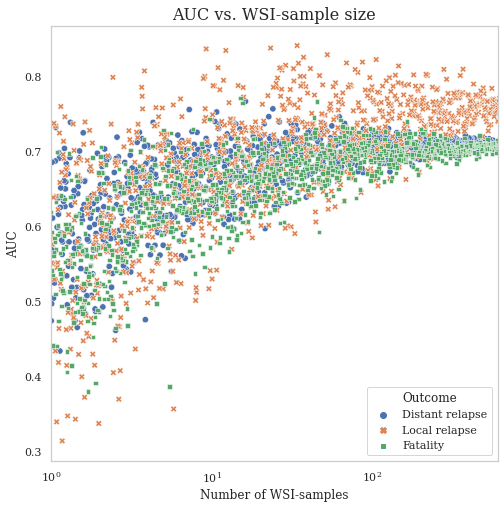

In [219]:
df = pd.concat([results_distant, results_local, results_dead])
plt.figure(figsize=(8,8))
#sns.lmplot(data=df, fit_reg=False, y="AUC", x="Number of samples", hue="Outcome", size=6, logx=True, x_jitter=True, legend_out=False, aspect=1, ci=False, scatter_kws={"s": 20})
sns.scatterplot(data=df, x_jitter=True,y="AUC", x="Number of samples", hue="Outcome", style="Outcome", s=40)
plt.xscale('log')
plt.xlabel("Number of WSI-samples")
plt.title("AUC vs. WSI-sample size", fontsize=16)
plt.savefig("../docs/auc_sample_size.svg", **fig_options)
plt.xlim((1,600))

In [ ]:
results_local = test_samples(df_wsi, df_local["formula"].iloc[0])
plt.figure()
sns.boxplot(data=results_distant, y="AUC", x="n_samples")

In [ ]:
formula = "distant_relapse ~ n_tumor*(tumor_tils1+tumor_cluster)"
print(results_distant["formula"].iloc[0])

df_wsi_sample = df_wsi.groupby("image_id").sample(400, replace=False)
df = merge_patient_data(df_wsi_sample, df_pat[df_pat["treated"] == 1])
df = df[features + ["distant_relapse"]].replace([np.inf, -np.inf], np.nan).dropna()
y, X = dmatrices(formula, df, NA_action="drop")
true, pred = cross_validation(y, X, logit)
auc = roc_auc_score(true, pred)
tpr, fpr, thresholds = roc_curve(true, pred)
print(auc)

In [ ]:
df_all["nodes"].isna().value_counts()

In [ ]:
import os 
from shutil import copyfile
path = "../data/tnbc_wsi/images/"
for image_name in os.listdir(path):
    pat_id =  pat_id_wsi(image_name)
    if pat_id in df_pat.index and df_pat.loc[pat_id]["treated"]:
        copyfile(os.path.join(path, image_name), "../data/tnbc_wsi/treated/" + image_name)

In [ ]:
df_pat["treated"].value_counts()